In [1]:
# # Sliding Window
# Feb 2019
#
import matplotlib.patches as patches
import seaborn as sns
import copy
import torchvision
from IPython.display import display  # to display images
from PIL import Image, ImageDraw
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt

import time
import os

from IPython.display import Audio

In [2]:
# Make dataset -------------------------------------------------------
IMG_X, IMG_Y = 200, 200
# length and width of blocks (fixed for now)
block_l, block_w = 20, 30


def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l / 2.0, w / 2.0), (l / 2.0, -w / 2.0),
                  (-l / 2.0, -w / 2.0), (-l / 2.0, w / 2.0), ]
    return [(c * x - s * y + offset[0],
             s * x + c * y + offset[1]) for (x, y) in rectCoords]


# ---- Make depth images ---
def make_dataset(dirname, num_images):
    true_coords = []
    newpath = "./" + dirname
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        print(newpath)
    for i in range(num_images):
        # orient = 0 # degrees
        img = Image.new("RGB", (IMG_X, IMG_Y), "black")

        # block_l and _w offset so blocks don't run off edge of image
        rand_x = int(np.random.rand() * (IMG_X - 2 * block_l)) + block_l
        rand_y = int(np.random.rand() * (IMG_Y - 2 * block_w)) + block_w
        orient = int(np.random.rand() * 180)  # .random() is range [0.0, 1.0).
        orient = math.radians(orient)  # math.cos takes radians!

        true_coords.append(np.array((rand_x, rand_y, orient)))

        rect_vertices = makeRectangle(
            block_l, block_w, orient, offset=(rand_x, rand_y))

        idraw = ImageDraw.Draw(img)
        idraw.polygon(rect_vertices, fill="white")

        img.save(newpath + "/rect" + str(i) + ".png")
    return true_coords


# NOTE Define size of dataset
train_truth = make_dataset("data", 1500)
# print(len(train_truth))
test_truth = make_dataset("./data/test", 300)

np.save("train_truth.npy", train_truth)
np.save("test_truth.npy", test_truth)


train_truth = np.load("train_truth.npy")
test_truth = np.load("test_truth.npy")  # loading the training and testing data

In [3]:

# Define Dataloader -------------------------------------------------------
class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        """
        """
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

        STEPSIZE = 50  # todo make this input arguments
        WINDOWSIZE = (100, 100)
        MARGIN_PX = 15
        self.step = STEPSIZE
        self.cropSize = WINDOWSIZE
        self.detectMargin = MARGIN_PX
        
        # go ahead and read size of the images (assume all same size)
        image = io.imread(self.img_dir + "/rect" +
                          "1" + ".png", as_gray=True)
        self._imgx, self._imgy = image.shape[1], image.shape[0]
        del image

    def __len__(self):
        # print('true coord len', len(self.true_coords))
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + "/rect" +
                          str(idx) + ".png", as_gray=True)
        # image = torch.FloatTensor(image).permute(2, 0, 1)  # PIL and torch expect difft orders
        coords = torch.FloatTensor(self.true_coords[idx])

        if self.transform:
            image = self.transform(image)

        labels, coordsPerCrop = self.makeCrops(self.step, self.cropSize, coords, self.detectMargin)

        sample = image, torch.FloatTensor(labels), torch.FloatTensor(coordsPerCrop)
        return sample

    def makeCrops(self, stepSize, windowSize, rectCenter, detectMargin):
        """
        Returns image crops, as well as T/F for those crops
        """
        c_x, c_y, theta = rectCenter
        margin = detectMargin
        hasObjs = []
        objCoords = []
        for y in range(0, self._imgy - windowSize[0] + 1, stepSize):
            for x in range(0, self._imgx - windowSize[1] + 1, stepSize):
                end_x, end_y = x + windowSize[1], y + windowSize[0]
                hasRect = (x + margin < c_x < end_x - margin) and (
                    y + margin < c_y < end_y - margin)
                hasObjs.append(hasRect)
                if hasRect:
                    objCoords.append((c_x, c_y, theta))
                else:
                    objCoords.append((-1, -1, -1))
        # print('length of truths in makeCrops', len(truths))
        return hasObjs, objCoords

In [4]:
# -- Define Loss -------------------------------------------------------

class MultiObjLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.
    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self):
        super(MultiObjLoss, self).__init__()
        #self.smooth_l1 = nn.L1Loss()
        self.smooth_l1 = nn.SmoothL1Loss()
        self.binary_cross_entropy = nn.BCELoss()
        self.MSE = nn.MSELoss()
        self.alpha = 10  # some weighting between class vs regr loss

    def forward(self, predicted_locs, predicted_classes, locs, labels):
        """
        Forward propagation.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        #batch_size = predicted_locs.size(0)
        #print('\n<<--- before shaping, locs size', locs.size(), '--->>>')
        #print('locs', locs)
        #print('\n<<--- Before shaping, Predicted locs size', predicted_locs.size(), '--->>>')
        #print('beofre shaping, plocs', predicted_locs)
        # TODO: Is this correct way to resize?? -------------------------->><<<<>>><<<
        predicted_locs = predicted_locs.view(-1,
                                             locs.size(1), locs.size(2))
        #print('\n<<--- After, Predicted locs size', predicted_locs.size(), '--->>>')
        #print('after shaping, plocs', predicted_locs)

        #loc_loss = self.smooth_l1(predicted_locs, locs)
        loc_loss = self.MSE(predicted_locs, locs)
        conf_loss = self.binary_cross_entropy(predicted_classes, labels)

        #return conf_loss + self.alpha * loc_loss
        return loc_loss

In [5]:
# two batchs, each batch of 2 images, with 2 sliding windows each
predloc = torch.FloatTensor([[1,1,1], [2,2,2]])
predloc = torch.cat((predloc, predloc))
trueloc = torch.FloatTensor([[1,1,2], [2,2,1]])
trueloc = torch.stack((trueloc, trueloc))

predclass = torch.FloatTensor([[0, 1], [1, 1]])
trueclass = torch.FloatTensor([[0, 0], [0, 1]])

crit = MultiObjLoss()
crit(predloc, predclass, trueloc, trueclass)

tensor(0.3333)

In [6]:
# -- Define NN -------------------------------------------------------

class myNet(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28x1)
    def __init__(self, IMG_X, IMG_Y):
        """ We need the image width and height to determine CNN layer sizes
        """
        super(myNet, self).__init__()
        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16

        STEPSIZE = 50  # todo make this input arguments
        WINDOWSIZE = (100, 100)
        self.step = STEPSIZE
        self.cropSize = WINDOWSIZE
        self.numCrops = 0
        # T/F for now

        # calculate number of crops
        for x in range(0, IMG_Y - WINDOWSIZE[0] + 1, STEPSIZE):
            for y in range(0, IMG_X - WINDOWSIZE[1] + 1, STEPSIZE):
                self.numCrops += 1
        # TODO: but our net wants everything to be the same size... pad with 0s?

        def _calc(val):  # use to calculate layer sizes
            layer_size = (val - (_stride - 1)) / _pool
            return layer_size

        # print(self._imgx)
        # self._const = _calc(_calc(self._imgx))
        # self._const *= _calc(_calc(self._imgy))
        self._const = _calc(_calc(self.cropSize[0]))
        self._const *= _calc(_calc(self.cropSize[1]))
        self._const *= _outputlayers
        self._const = int(self._const)

        # --- CLASSIFICATION OF WINDOWS
        # batch, 3 input image channels (RGB), 6 output channels, 5x5 square convolution
        # NOTE: we switched to 1 input channel
        self.c_conv1 = nn.Conv2d(self.numCrops, 6, _stride).to(device)
        self.c_pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.c_conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.c_fc1 = nn.Linear(self._const, 120).to(device)
        self.c_fc2 = nn.Linear(120, 84).to(device)
        self.c_fc3 = nn.Linear(84, self.numCrops).to(device)
        self.c_sigmoid = nn.Sigmoid()
        # TODO: batch normalization  self.bn = nn.BatchNorm2d()

        # --- LOCATION OF RECTANGLE
        self.l_conv1 = nn.Conv2d(self.numCrops, 6, _stride).to(device)
        self.l_pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.l_conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.l_fc1 = nn.Linear(self._const, 120).to(device)
        self.l_fc2 = nn.Linear(120, 84).to(device)
        self.l_fc3 = nn.Linear(84, 3 * self.numCrops).to(device)
        # TODO: what if there are multiple rectnagles?????
        # I thought that was the whole point of the sliding windows
        # How to deal with potential unknown number of objects
        # for now... let's just assume there's at most one rectangle per sliding
        # window... = 3 (x,y, theta) * self.numCrops
        #self.l_sigmoid = nn.Sigmoid() # NO BUG ! 

    # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
    # self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
    # Class prediction convolutions (predict classes in localization boxes)
    # self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)

    def forward(self, x):
        """
        Forward propogation
        :param image: images, a tensor of dimensions (N, 3, IMG_X, IMG_Y)
        :return: (x,y, theta) and T/F for each window 
        """
        # TODO: Wait, if we're going to return a regression for each window,
        # do we even need classif? We can just say (-99,-99) to denote no rect
        # NOTE: Let (No Rect) = (-1,-1,-1) for localization

        x = x.to(device)
        # TODO: presumably by doing this i lose some of the multithread goodness
        batch_images = x

        all_crops = []
        for img in batch_images:
            crops = self.makeCrops(img, self.step, self.cropSize)
            all_crops.append(crops)
            # all_crops.append(crops)
        all_crops = torch.stack(all_crops)
        # gray=1
        # we want, batch_size, [100x100]*numcrops 4 dims
        # TODO is this even right # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! <<<<-----------------------
        feats = all_crops.view(-1, self.numCrops, self.cropSize[0],
                               self.cropSize[1]).to(device)

        # CLASSIFICATION of the windows
        c_crops = self.c_pool(F.relu((self.c_conv1(feats))))
        c_crops = self.c_pool(F.relu(self.c_conv2(c_crops)))
        c_crops = c_crops.view(-1, self._const)
        c_crops = F.relu(self.c_fc1(c_crops))
        c_crops = F.relu(self.c_fc2(c_crops))
        c_crops = self.c_fc3(c_crops)
        c_crops = self.c_sigmoid(c_crops)

        # LOCALIZATION
        regr_crops = self.l_pool(F.relu((self.l_conv1(feats))))
        regr_crops = self.l_pool(F.relu(self.l_conv2(regr_crops)))
        regr_crops = regr_crops.view(-1, self._const)
        regr_crops = F.relu(self.l_fc1(regr_crops))
        regr_crops = F.relu(self.l_fc2(regr_crops))
        regr_crops = self.l_fc3(regr_crops)
        #regr_crops = self.l_sigmoid(regr_crops) # NO BUG!

        containsRect = c_crops
        rectCoords = regr_crops
        return containsRect, rectCoords

    def makeCrops(self, image, stepSize, windowSize):
        """
        Returns a generator of cropped boxes(the top left x, y, the image data)
        """
        image = image.type(torch.FloatTensor).to(device)
        crops = []

        # TODO: look into ordering, why it's y,x !
        for y in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
            for x in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
                end_x, end_y = x + windowSize[1], y + windowSize[0]
                # print('This is the x and y used: ', x, '; ', y)
                crops.append(image[y:end_y, x:end_x])
        crops = torch.stack(crops)
        # self.numCrops=len(crops)
        return crops

In [7]:
# -- Utility fxn -------------------------------------------------------
# Source: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/train.py

class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(
    epoch, epochs_since_improvement, model, optimizer, loss, best_loss, is_best
):
    """
    Save model checkpoint.
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {
        "epoch": epoch,
        "epochs_since_improvement": epochs_since_improvement,
        "loss": loss,
        "best_loss": best_loss,
        "model": model,
        "optimizer": optimizer,
    }
    filename = "checkpoint_v2sliding.pth.tar"
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, "BEST_" + filename)

In [8]:

# -- Define Train and Valid fxn -------------------------------------------------------

def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """

    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss
    start = time.time()

    for i_batch, (images, labels, coords) in enumerate(train_loader):
        data_time.update(time.time() - start)

        images = images.to(device)
        labels = labels.to(device)
        coords = coords.to(device)

        # Forward pass
        predicted_class, predicted_locs = model(images)
        loss = criterion(predicted_locs, predicted_class, coords, labels)

        # Backward prop
        optimizer.zero_grad()
        loss.backward()

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)
        start = time.time()

        # Print status
        if i_batch % print_freq == 0:
            print(
                "Epoch: [{0}][{1}/{2}]\t"
                "Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                "Loss {loss.val:.4f} ({loss.avg:.4f})\t".format(
                    epoch,
                    i_batch,
                    len(train_loader),
                    batch_time=batch_time,
                    loss=losses,
                )
            )
        # free some memory since their histories may be stored
        del predicted_locs, predicted_class, images, labels, coords

In [9]:
def validate(val_loader, model, criterion):
    """
    One epoch's validation.
    :param val_loader: DataLoader for validation data
    :param model: model
    :param criterion: MultiBox loss
    :return: average validation loss
    """
    model.eval()  # eval mode disables dropout

    batch_time = AverageMeter()
    losses = AverageMeter()

    start = time.time()

    # Prohibit gradient computation explicity because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i_batch, (images, labels, coords) in enumerate(train_loader):

            # Move to default device
            images = images.to(device)
            labels = labels.to(device)
            coords = coords.to(device)

            # Forward pass
            predicted_class, predicted_locs = model(images)

            # Loss
            loss = criterion(predicted_locs, predicted_class, coords, labels)

            losses.update(loss.item(), images.size(0))
            batch_time.update(time.time() - start)

            start = time.time()

            # Print status
            if i_batch % print_freq == 0:
                print(
                    "[{0}/{1}]\t"
                    "Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                    "Loss {loss.val:.4f} ({loss.avg:.4f})\t".format(
                        i_batch, len(val_loader), batch_time=batch_time, loss=losses
                    )
                )

    print("\n * LOSS - {loss.avg:.3f}\n".format(loss=losses))

    return losses.avg

In [10]:
# -- Load data -------------------------------------------------------
batch_size = 15

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA available? device: ", device)


# Dataset is depth images of rectangular blocks
train_dataset = RectDepthImgsDataset(img_dir="./data", coords=train_truth)

# Data loader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, shuffle=True)

test_dataset = RectDepthImgsDataset(img_dir="./data/test", coords=test_truth)

# Data loader
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size, shuffle=True)

CUDA available? device:  cuda:0


In [11]:
# -- Hyperparamaters -------------------------

num_epochs = 15  # number of epochs to run without early-stopping
learning_rate = 0.001

start_epoch = 0  # start at this epoch
# number of epochs since there was an improvement in the validation metric
epochs_since_improvement = 0
best_loss = 100.0  # assume a high loss at first
workers = 4  # number of workers for loading data in the DataLoader

model = myNet(IMG_X, IMG_Y)
model = model.to(device)

#criterion = nn.BCELoss()
criterion = MultiObjLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
#                             momentum=momentum, weight_decay=weight_decay)

print_freq = 25  # print training or validation status every __ batches

In [12]:
def main():
    """
    Training and validation.
    """

    global epochs_since_improvement, start_epoch, best_loss, epoch, checkpoint

    print("Training model now...")

    # -- Begin training -------------------------

    for epoch in range(num_epochs):
        train(
            train_loader=train_loader,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            epoch=epoch,
        )

        # One epoch's validation
        val_loss = validate(val_loader=test_loader,
                            model=model, criterion=criterion)

        # Did validation loss improve?
        is_best = val_loss < best_loss
        best_loss = min(val_loss, best_loss)

        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" %
                  (epochs_since_improvement,))

        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(epoch, epochs_since_improvement, model, optimizer,
                        val_loss, best_loss, is_best)

In [13]:
main()

# alert when training is done
sound_file = '/home/rui/Downloads/newyear.ogg'
Audio(sound_file, autoplay=True)

Training model now...
Epoch: [0][0/100]	Batch Time 0.030 (0.030)	Loss 1375.9642 (1375.9642)	
Epoch: [0][25/100]	Batch Time 0.024 (0.024)	Loss 951.2509 (1270.0276)	
Epoch: [0][50/100]	Batch Time 0.023 (0.024)	Loss 1056.1882 (1152.4979)	
Epoch: [0][75/100]	Batch Time 0.024 (0.024)	Loss 722.8043 (1052.8333)	
[0/20]	Batch Time 0.022 (0.022)	Loss 720.7582 (720.7582)	
[25/20]	Batch Time 0.024 (0.023)	Loss 663.3539 (625.5845)	
[50/20]	Batch Time 0.022 (0.022)	Loss 568.7843 (623.0197)	
[75/20]	Batch Time 0.021 (0.022)	Loss 694.3763 (620.0551)	

 * LOSS - 633.998


Epochs since last improvement: 1

Epoch: [1][0/100]	Batch Time 0.026 (0.026)	Loss 529.3079 (529.3079)	


/home/rui/mlenv/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type myNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1][25/100]	Batch Time 0.028 (0.025)	Loss 524.3864 (571.6004)	
Epoch: [1][50/100]	Batch Time 0.028 (0.027)	Loss 371.8374 (510.9683)	
Epoch: [1][75/100]	Batch Time 0.024 (0.026)	Loss 212.3574 (451.0476)	
[0/20]	Batch Time 0.022 (0.022)	Loss 207.1026 (207.1026)	
[25/20]	Batch Time 0.021 (0.022)	Loss 211.5769 (215.7324)	
[50/20]	Batch Time 0.021 (0.021)	Loss 280.6635 (217.6628)	
[75/20]	Batch Time 0.021 (0.022)	Loss 222.1629 (218.0072)	

 * LOSS - 223.456


Epochs since last improvement: 2

Epoch: [2][0/100]	Batch Time 0.024 (0.024)	Loss 258.0966 (258.0966)	
Epoch: [2][25/100]	Batch Time 0.024 (0.024)	Loss 139.0146 (201.3577)	
Epoch: [2][50/100]	Batch Time 0.024 (0.024)	Loss 198.2061 (200.8676)	
Epoch: [2][75/100]	Batch Time 0.024 (0.024)	Loss 152.2266 (190.2664)	
[0/20]	Batch Time 0.022 (0.022)	Loss 145.1590 (145.1590)	
[25/20]	Batch Time 0.021 (0.022)	Loss 113.5970 (138.7792)	
[50/20]	Batch Time 0.026 (0.022)	Loss 171.1264 (150.3582)	
[75/20]	Batch Time 0.026 (0.023)	Loss 250.135

In [14]:
print('All Ready!')


filename = "checkpoint_v2sliding.pth.tar"
checkpoint = torch.load(filename)
start_epoch = checkpoint['epoch'] + 1
best_loss = checkpoint['best_loss']
print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
model = checkpoint['model']


All Ready!

Loaded checkpoint from epoch 15. Best loss so far is 42.365.





FOR N =  1
tensor([0., 0., 0., 1., 1., 0., 0., 0., 0.])
[67.0, 95.0, 2.1467549800872803]


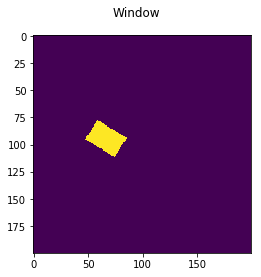

In [15]:
dataiter = iter(test_loader)
images, labels, coords = dataiter.next()

n = 1
print("\n\nFOR N = ", n)
imgSample = images[n]
max_idx = torch.argmax(coords[n][:,0])
x, y, theta = coords[n][max_idx]
print(labels[n])
print([float(zed) for zed in (x,y,theta)])
#print(x,y,theta)
#crops, __ = makeCrops(imgSample, 50, (100, 100), (x,y, theta))

plt.imshow(imgSample)
#fig, axess = plt.subplots(3,3, figsize=(10,10))
#axess = np.array(axess).flatten()#order='F') #'F' means to flatten in column-major (Fortran- style) order.
#for i in range(9):
#    axess[i].imshow(crops[i])
#    axess[i].set_ylabel('# '+str(i))
plt.suptitle('Window')
plt.show()



In [16]:
# -- Check the results -------------------------------------------------------

# -- Utility ---------------------------------------------
def makeCrops(image, stepSize, windowSize, true_center):
    """
    """
    image = image.type(torch.FloatTensor)
    crops = []
    truths = []
    c_x, c_y, orient = true_center
    # TODO: look into otdering, why it's y,x !
    margin = 15
    # --> is x, but is the column
    # to slide horizontally, y must come first
    for y in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
        for x in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
            end_x, end_y = x + windowSize[1], y + windowSize[0]
            hasRect = (x + margin < c_x < end_x - margin) and (
                y + margin < c_y < end_y - margin
            )
            truths.append(hasRect)
            crops.append(image[y:end_y, x:end_x])
    crops = torch.stack(crops)
    print("shape of crops", crops.shape)
    return crops, truths


# -- Get some validation results ---------------------------------------------
model.to(device).eval()
with torch.no_grad():
    dataiter = iter(test_loader)
    images, labels, coords = dataiter.next()
    
    # Move to default device
    images = images.to(device)
    labels = labels.to(device)
    coords = coords.to(device)

    # Forward pass
    predicted_class, predicted_locs = model(images)

    # Loss
    loss = criterion(predicted_locs, predicted_class, coords, labels)

print("loss across batch size of ", labels.size()[0], 'is: ', loss)

loss across batch size of  15 is:  tensor(111.5376, device='cuda:0')


shape of crops torch.Size([9, 100, 100])
!-- FOR N =  1
y (crops) 
	 [0, 0, 0, 0, 0, 1, 0, 0, 0]
!-- yhat (crops) 
	 [1, 1, 0, 0, 1, 0, 0, 1, 0]


FOR N =  1
!-- center y 
	 [153.0, 88.0, 0.15707963705062866]
!-- center y est 
	  [146.50486755371094, 85.4399642944336, 1.5212398767471313]
tensor([[ -0.8731,  -0.5686,  -1.0426],
        [ -2.9115,  -1.2275,  -1.4668],
        [ 27.2432,  17.6353,  -1.1234],
        [  1.4357,   1.7148,  -1.0339],
        [ -7.0436,  -5.8655,   0.4804],
        [146.5049,  85.4400,   1.5212],
        [ -0.5862,  -1.0086,  -0.6958],
        [  1.9103,   1.1571,  -1.0467],
        [ -0.1243,   2.5297,  -0.0402]], device='cuda:0')


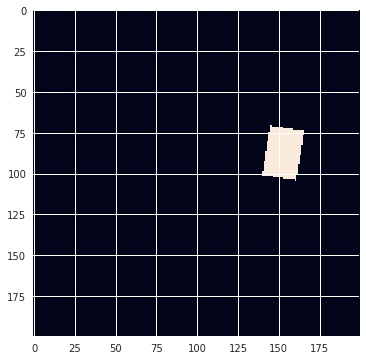

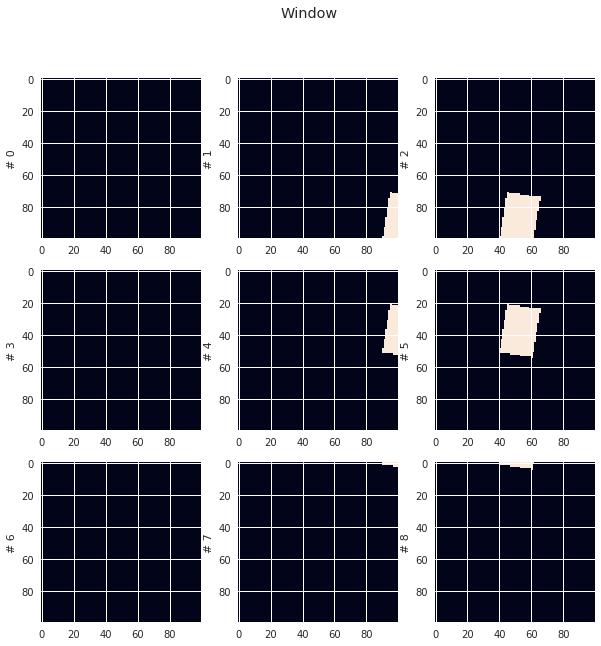

In [19]:
# -- Plot windows and print labels -----------------------------------
n = 1
imgSample = images[n]
crops, __ = makeCrops(imgSample, 50, (100, 100), (x,y, theta))
# -- Show original image, and the sliding windo crops -------
plt.imshow(imgSample)
# ---------------------------------------------------
foo_label = labels[n]

foo_coord = coords[n] 
predicted_locs = predicted_locs.view(-1,
                                     coords.size(1), coords.size(2))
foo_coord_est = predicted_locs[n] # 3 per window
foo_label_est = predicted_class[n]

max_idx = torch.argmax(foo_coord[:,0])
x, y, theta = foo_coord[max_idx]
est_max_idx = torch.argmax(foo_coord_est[:,0])
x_est, y_est, theta_est = foo_coord_est[est_max_idx]

# -- Print x,y for one result -------
# -- Print window t/f for one result -------
print("!-- FOR N = ", n)
print("y (crops) \n\t", [int(l) for l in foo_label])
print("!-- yhat (crops) \n\t", [int(np.round(p,0)) for p in foo_label_est] )
# -------------------------------------------------
sns.set(rc={"figure.figsize": (8, 6)})

print("\n\nFOR N = ", n)
print("!-- center y \n\t", [float(zed) for zed in (x, y, theta)])
print("!-- center y est \n\t ", [float(zed) for zed in (x_est, y_est, theta_est)])
print(foo_coord_est)

fig, axess = plt.subplots(3,3, figsize=(10,10))
axess = np.array(axess).flatten()#order='F') #'F' means to flatten in column-major (Fortran- style) order.
for i in range(9):
    axess[i].imshow(crops[i])
    axess[i].set_ylabel('# '+str(i))
plt.suptitle('Window')
plt.show()

#for (i, crop) in enumerate(crops):
    # print("1-index number of window: ", i+1, 'x', x, 'y', y, 'has rectangle?', hasRect)
    #plt.figure()
    #plt.suptitle("numero: %d" % (i))
    #plt.imshow(crop)

In [18]:
#print("!-- yhat \n\t", [int(round(o, 0)) for o in outputs[n].cpu().numpy()])    
print("!-- ")
print('True locations, defined for each crop\n', foo_coord)
print("!-- ")
print('Full predicted locations (3 per crop)\n', foo_coord_est)
#print("\n ------ x,y center + orient: ", coords[n], "\n"))
print(np.argwhere(foo_coord_est > 0) )

# -- Print outputs for multiple results -------
for ix in range(5):
    print('\nSAMPLE ', ix)
    print("!-- y (crops) \n\t", [int(l) for l in labels[ix]])
    print("!-- yhat (crops) \n\t", [int(np.round(p, 0)) for p in predicted_class[ix]] )

# -- Main ---------------------------------------------
#if __name__ == '__main__':
    #main()

!-- 
True locations, defined for each crop
 tensor([[ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [153.0000,  88.0000,   0.1571],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000]], device='cuda:0')
!-- 
Full predicted locations (3 per crop)
 tensor([[ -0.8731,  -0.5686,  -1.0426],
        [ -2.9115,  -1.2275,  -1.4668],
        [ 27.2432,  17.6353,  -1.1234],
        [  1.4357,   1.7148,  -1.0339],
        [ -7.0436,  -5.8655,   0.4804],
        [146.5049,  85.4400,   1.5212],
        [ -0.5862,  -1.0086,  -0.6958],
        [  1.9103,   1.1571,  -1.0467],
        [ -0.1243,   2.5297,  -0.0402]], device='cuda:0')
tensor([[2, 2, 3, 3, 4, 5, 5, 5, 7, 7, 8],
        [0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 1]])

SAMPLE  0
!-- y (crops) 
	 [0, 1, 1, 0, 0, 0, 0, 0, 0]
!-- yhat (cro